In [16]:
data_splits_num = {
    'train': 3071
}
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from preprocessing import ssd_preprocessing
slim = tf.contrib.slim
import os
import json
# 获取数据集
current=os.getcwd()
DATADIR = os.path.abspath(os.path.join(current,os.path.pardir,'dataset/data'))
IMG_PATH=DATADIR+'/test'
MARK_PATH=DATADIR+'/marks' 
# 位置标记文件
filedir=DATADIR+'/annotations.json'
# 每张图片名称所关联的id
ids=open(DATADIR+'/test/ids.txt').read().splitlines()
anns=json.loads(open(filedir).read())
# print('anns',anns['types'])
# 为类别生成数字编号
targets=anns['types']
target_classes=dict()
for i,name in enumerate(targets):
    target_classes[name]=i+1
#     当读取不到数据，为背景图
target_classes['None']=0
labels=target_classes

Da /mnt/Data/weiyumei/deeplearning/dataset/data


In [5]:

def slim_get_batch(num_classes, batch_size, split_name, file_pattern, num_readers, num_epochs=None, is_training=True):
    """获取一个数据集元组，其中包含有关读取P数据集的说明。
    Args:
      num_classes:数据集中的总类数。
      batch_size: the size of each batch.
      split_name: 'train' of 'val'.
      file_pattern: 匹配数据集源时使用的文件模式（完整路径）。
      num_readers: 用于阅读tfrecords的最大阅读器数量。
      num_preprocessing_threads: 用于运行预处理功能的最大线程数。
      image_preprocessing_fn: 用于数据集扩充的函数。
      anchor_encoder: 用于编码所有锚点的函数。
      num_epochs: 用于迭代此数据集的总epoches。
      is_training: 
    Returns:     allow_smaller_final_batch=(not is_training),
                    num_threads=num_preprocessing_threads,
                    capacity=64 * batch_size)
    """     
    if split_name not in data_splits_num:
        raise ValueError('split name %s was not recognized.' % split_name)

    # Features in Pascal VOC TFRecords.
    keys_to_features = {
        'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/format': tf.FixedLenFeature((), tf.string, default_value='jpeg'),
        'image/filename': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/height': tf.FixedLenFeature([1], tf.int64),
        'image/width': tf.FixedLenFeature([1], tf.int64),
        'image/channels': tf.FixedLenFeature([1], tf.int64),
        'image/shape': tf.FixedLenFeature([3], tf.int64),
        'image/object/bbox/xmin': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/ymin': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/xmax': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/ymax': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/label': tf.VarLenFeature(dtype=tf.int64),
    }
    items_to_handlers = {
        'image': slim.tfexample_decoder.Image('image/encoded', 'image/format'),
        'filename': slim.tfexample_decoder.Tensor('image/filename'),
        'shape': slim.tfexample_decoder.Tensor('image/shape'),
        'object/bbox': slim.tfexample_decoder.BoundingBox(
                ['ymin', 'xmin', 'ymax', 'xmax'], 'image/object/bbox/'),
        'object/label': slim.tfexample_decoder.Tensor('image/object/bbox/label'),
    }
    decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)

    labels_to_names = {}
    for name, pair in target_classes.items():
        labels_to_names[pair] = name

    dataset = slim.dataset.Dataset(
                data_sources=file_pattern,
                reader=tf.TFRecordReader,
                decoder=decoder,
                num_samples=data_splits_num[split_name],
                items_to_descriptions=None,
                num_classes=num_classes,
                labels_to_names=labels_to_names)

    with tf.name_scope('dataset_data_provider'):
        provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset,
            num_readers=num_readers,
            common_queue_capacity=32 * batch_size,
            common_queue_min=8 * batch_size,
            shuffle=is_training,
            num_epochs=num_epochs)

    [image, filename, shape, glabels_raw, gbboxes_raw] = provider.get(['image', 'filename', 'shape',
                                                                     'object/label',
                                                                     'object/bbox'])

    with tf.Session() as sess:
            sess.run([tf.local_variables_initializer(),tf.global_variables_initializer()])
            tf.train.start_queue_runners()
            for i in range(provider._num_samples):
                [image, labelList, boxList, shape, filename1] = provider.get(['image', 'object/label', 'object/bbox', 'shape', 'filename'])
                img, labels, boxes, shape, filename = sess.run([image, labelList, boxList, shape, filename1])
                print(labelList)
                
                print('{}is ,{} has shape :{}'.format(image,filename.decode('utf-8'), shape))
                for j in range(labels.shape[0]):
                    print('label=%d (%s): locations in %.6f, %.6f, %.6f, %.6f' % (labels[j], labels_to_names[labels[j]], boxes[j][0], boxes[j][1], boxes[j][2], boxes[j][3]))
                break

#     return tf.train.batch([image, filename, shape, gt_targets, gt_labels],
#                     dynamic_pad=False,
#                     batch_size=batch_size,
#                     allow_smaller_final_batch=(not is_training),
#                     num_threads=num_preprocessing_threads,
#                     capacity=64 * batch_size)

In [6]:
def count_split_examples(split_path, file_prefix='.tfrecord'):
    # Count the total number of examples in all of these shard
    num_samples = 0
    tfrecords_to_count = tf.gfile.Glob(os.path.join(split_path, file_prefix))
    opts = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.ZLIB)
    for tfrecord_file in tfrecords_to_count:
        for record in tf.python_io.tf_record_iterator(tfrecord_file):#, options = opts):
            num_samples += 1
    return num_samples


In [7]:
if __name__ == '__main__':
    output_directory=DATADIR+'/Tfrecords'
    print('train:', count_split_examples(output_directory, 'train-?????-of-?????'))
#     print('val:', count_split_examples('/media/rs/7A0EE8880EE83EAF/Detections/SSD/dataset/tfrecords', 'val-?????-of-?????'))


train: 3071


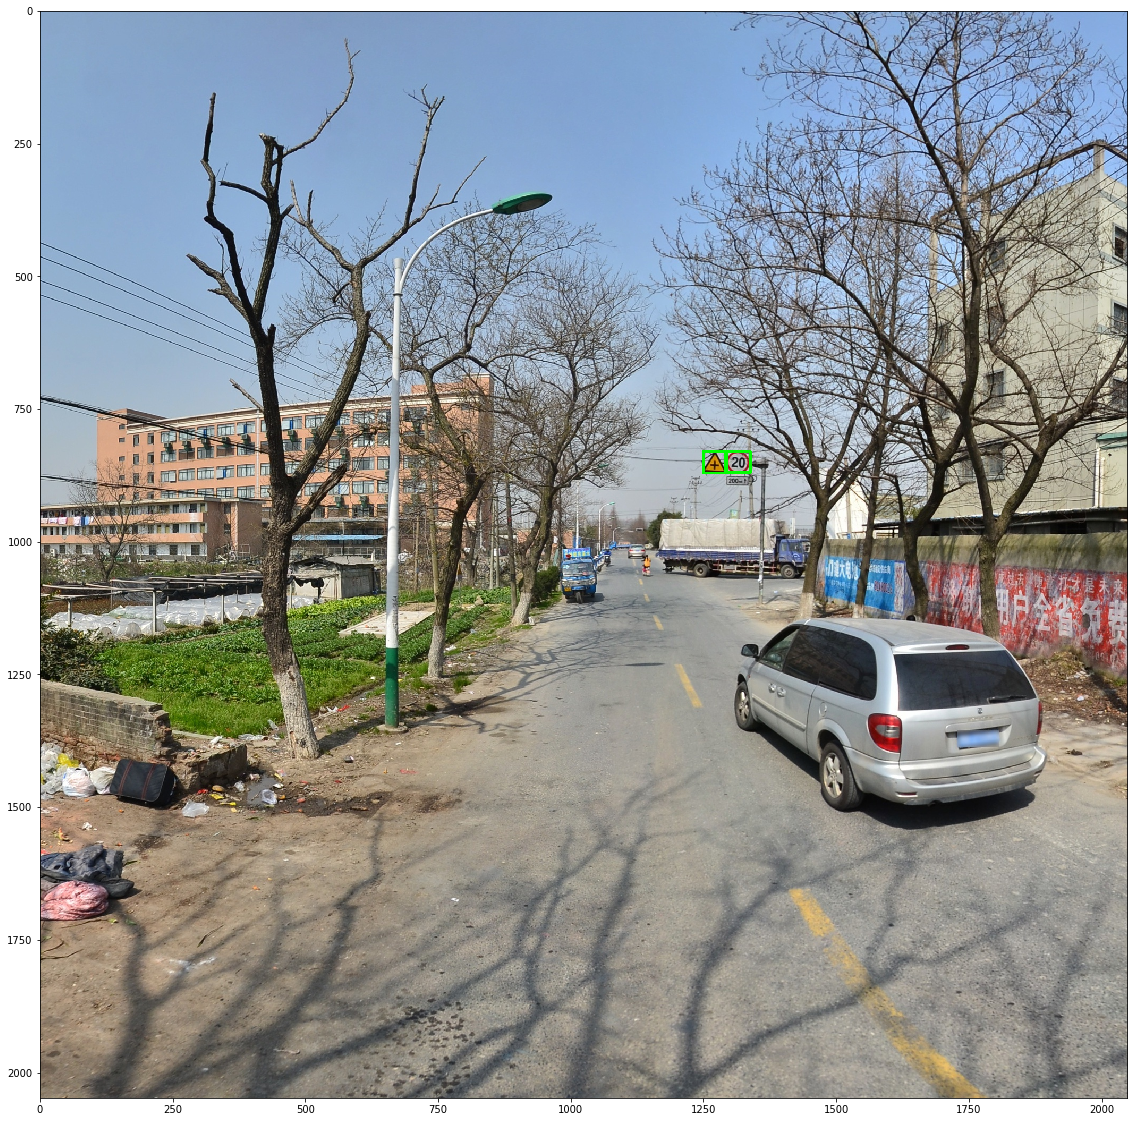

In [9]:
# slim_get_batch(222,10,'train',DATADIR+'/Tfrecords/train-*',100,4,)
#img_path 31336.jpg
# label=134 (w13): locations in 1248.410034, 830.158020, 1290.476196, 871.428223
# label=82 (pl20): locations in 1292.859985, 830.158997, 1337.297852, 870.634888
    
import matplotlib    
import matplotlib.pyplot as plt 
import cv2

path=r'/mnt/Data/weiyumei/deeplearning/dataset/data/test/31336.jpg'
origin=cv2.imread(path)
cv2.rectangle(origin,(int(1248.410034),int(830.158020)),(int(1290.476196),int( 871.428223)),(0,255,0),3)
cv2.rectangle(origin,(int(1292.859985),int(830.158997)),(int(1337.297852),int( 870.634888)),(0,255,0),3)

origin=cv2.cvtColor(origin,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(origin)
plt.show()